# Sentiment analysis with GRU and LSTM

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import tensorflow as tf
import collections
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Input, GRU,Activation, Dropout, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, backend as K
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from numpy import array, asarray, zeros
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight 

# download nltk resources
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('omw-1.4')

# need to unzip nltk resources manually on notebook
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/stopwords/ 
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/omw-1.4/ 

2024-04-19 21:20:50.591593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 21:20:50.591705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 21:20:50.728991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_dat

In [2]:
# global params
VOCAB_SIZE = 5000
NUM_EPOCHS = 20
BATCH_SIZE = 64

# Load the data

In [3]:
# load data from files
train_ds = pd.read_csv("/kaggle/input/sentiment-analysis-on-ekmans-emotions/train_ekmann.csv")
test_ds = pd.read_csv("/kaggle/input/sentiment-analysis-on-ekmans-emotions/test_ekmann.csv")
val_ds = pd.read_csv("/kaggle/input/sentiment-analysis-on-ekmans-emotions/val_ekmann.csv")

# remove Id column
train_ds = train_ds.drop('Id', axis=1)
test_ds = test_ds.drop('Id', axis=1)
val_ds = val_ds.drop('Id', axis=1)

# Data visualization

In [4]:
train_ds.shape

(43410, 2)

In [5]:
train_ds.head

<bound method NDFrame.head of                                                     Text   Emotion
0      My favourite food is anything I didn't have to...   neutral
1      Now if he does off himself, everyone will thin...   neutral
2                         WHY THE FUCK IS BAYLESS ISOING     anger
3                            To make her feel threatened      fear
4                                 Dirty Southern Wankers     anger
...                                                  ...       ...
43405  Added you mate well I’ve just got the bow and ...       joy
43406  Always thought that was funny but is it a refe...  surprise
43407  What are you talking about? Anything bad that ...     anger
43408            More like a baptism, with sexy results!       joy
43409                                    Enjoy the ride!       joy

[43410 rows x 2 columns]>

<Axes: xlabel='Emotion', ylabel='count'>

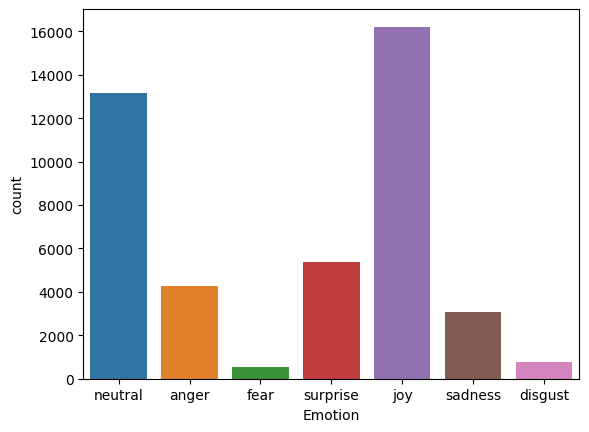

In [6]:
# emotion distribution
sns.countplot(x='Emotion', data=train_ds)

# Preprocessing

In [7]:
def preprocess_text(sentence):
    # to lower case
    sentence = sentence.lower()
    # remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [8]:
# lemmatize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [9]:
def map_emotion(emotion):
    if emotion == "neutral":
        return 0
    elif emotion == "anger":
        return 1
    elif emotion == "sadness":
        return 2
    elif emotion == "fear":
        return 3
    elif emotion == "disgust":
        return 4
    elif emotion == "surprise":
        return 5
    elif emotion == "joy":
        return 6
    else:
      return -1

In [10]:
# preprocess all dataframes
train_ds['Text'] = train_ds['Text'].apply(lambda x: preprocess_text(x))
train_ds['Text'] = train_ds['Text'].apply(lambda x: lemmatize(x))
print(train_ds['Text'][0])

test_ds['Text'] = test_ds['Text'].apply(lambda x: preprocess_text(x))
test_ds['Text'] = test_ds['Text'].apply(lambda x: lemmatize(x))
print(test_ds['Text'][0])

val_ds['Text'] = val_ds['Text'].apply(lambda x: preprocess_text(x))
val_ds['Text'] = val_ds['Text'].apply(lambda x: lemmatize(x))
print(val_ds['Text'][0])

['my', 'favourite', 'food', 'is', 'anything', 'i', 'didn', 't', 'have', 'to', 'cook', 'myself']
['i', 'm', 'really', 'sorry', 'about', 'your', 'situation', 'although', 'i', 'love', 'the', 'name', 'sapphira', 'cirilla', 'and', 'scarlett']
['is', 'this', 'in', 'new', 'orleans', 'i', 'really', 'feel', 'like', 'this', 'is', 'new', 'orleans']


In [11]:
# prepare arrays for model
y_train = train_ds['Emotion'].values.tolist()
y_train = np.array(list(map(lambda x: map_emotion(x), y_train)))
X_train = train_ds["Text"].values.tolist()

y_test = test_ds['Emotion'].values.tolist()
y_test = np.array(list(map(lambda x: map_emotion(x), y_test)))
X_test = test_ds["Text"].values.tolist()

y_val = val_ds['Emotion'].values.tolist()
y_val = np.array(list(map(lambda x: map_emotion(x), y_val)))
X_val = val_ds["Text"].values.tolist()

In [12]:
# initialize tokenizer on train set 
tk = Tokenizer(num_words=VOCAB_SIZE,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

# transform words in sequences of int
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_val_seq = tk.texts_to_sequences(X_val)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

Fitted tokenizer on 43410 documents
Top 5 most common words are: [('i', 20778), ('the', 18003), ('a', 14536), ('to', 12600), ('you', 11459)]
"['my', 'favourite', 'food', 'is', 'anything', 'i', 'didn', 't', 'have', 'to', 'cook', 'myself']" is converted into [18, 1061, 471, 9, 202, 1, 112, 14, 26, 4, 2784, 350]


In [13]:
# padding each array to max lenght of sequences within the array
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, padding="post")
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, padding="post")
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, padding="post")

print("Shapes before padding:")
print(X_train_seq.shape)
print(X_test_seq.shape)
print(X_val_seq.shape)

# pad each array to the longest of the three arrays so they are all same length
max_padding = max(max(X_train_seq.shape[1], X_test_seq.shape[1]), X_val_seq.shape[1])
print(max_padding)

if (X_train_seq.shape[1] < max_padding):
    padding_val_train = max_padding - X_train_seq.shape[1] 
    X_train_seq = np.pad(X_train_seq, [(0, 0), (0, padding_val_train)], mode='constant', constant_values=0)

if (X_test_seq.shape[1] < max_padding):
    padding_val_test = max_padding - X_test_seq.shape[1]
    X_test_seq = np.pad(X_test_seq, [(0, 0), (0, padding_val_test)], mode='constant', constant_values=0)

if (X_val_seq.shape[1] < max_padding):
    padding_val_val = max_padding - X_val_seq.shape[1] 
    X_val_seq = np.pad(X_val_seq, [(0, 0), (0, padding_val_val)], mode='constant', constant_values=0)

print("Shapes after padding:")
print(X_train_seq.shape)
print(X_test_seq.shape)
print(X_val_seq.shape)

Shapes before padding:
(43410, 32)
(5427, 30)
(5426, 30)
32
Shapes after padding:
(43410, 32)
(5427, 32)
(5426, 32)


In [14]:
# one hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
y_val_oh = to_categorical(y_val)

print('eg: {} -> {}'.format(y_train[10], y_train_oh[10]))

eg: 5 -> [0. 0. 0. 0. 0. 1. 0.]


# Bidirectional LSTM

## Build model

In [15]:
input = Input(shape=(max_padding,))
x = Embedding(input_dim=VOCAB_SIZE,output_dim=256, input_length=max_padding)(input)
x = Dropout(0.8)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128))(x)
x = Dense(7, activation='softmax')(x)
model_lstm = Model(inputs=input, outputs=x)
model_lstm.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 32, 256)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,070,279 (7.90 MB)

 Trainable params: 2,070,279 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2, verbose=1)

model_lstm.compile(optimizer='adam'
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_seq
                    , y_train_oh
                    , epochs=NUM_EPOCHS
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_val_seq, y_val_oh)
                    , verbose=1
                    , callbacks=[early_stopping_callback])

Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4637 - loss: 1.4029 - val_accuracy: 0.6137 - val_loss: 1.0838
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6102 - loss: 1.0814 - val_accuracy: 0.6344 - val_loss: 1.0017
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6397 - loss: 0.9868 - val_accuracy: 0.6388 - val_loss: 0.9760
Epoch 4/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6556 - loss: 0.9397 - val_accuracy: 0.6399 - val_loss: 0.9701
Epoch 5/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6681 - loss: 0.9032 - val_accuracy: 0.6386 - val_loss: 0.9756
Epoch 6/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6824 - loss: 0.8633 - val_accuracy: 0.6412 - val_loss: 0.9861
Epoch 6: early stopping


## Prediction and scores

In [17]:
y_true, y_pred = y_test_oh, model_lstm.predict(X_test_seq)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [18]:
class_names = np.unique(train_ds["Emotion"])

# hot encode y_pred
y_pred_cat = to_categorical(np.argmax(y_pred, axis=1), 7)

# classification report
print("Classification report (LSTM):")
print()
print(classification_report(y_true, y_pred_cat, target_names=class_names))

# f1 macro score
print("Macro avg f1 score:", f1_score(y_true, y_pred_cat, average='macro'))

Classification report (LSTM):

              precision    recall  f1-score   support

       anger       0.55      0.78      0.64      1648
     disgust       0.55      0.32      0.40       572
        fear       0.68      0.48      0.56       355
         joy       0.84      0.46      0.59        81
     neutral       0.56      0.41      0.48       116
     sadness       0.59      0.38      0.46       677
    surprise       0.78      0.76      0.77      1978

   micro avg       0.64      0.64      0.64      5427
   macro avg       0.65      0.51      0.56      5427
weighted avg       0.65      0.64      0.63      5427
 samples avg       0.64      0.64      0.64      5427

Macro avg f1 score: 0.5591748540681885


# GRU

## Build the model

In [19]:
input = Input(shape=(max_padding,))
x = Embedding(input_dim=VOCAB_SIZE,output_dim=256, input_length=max_padding)(input)
x = Dropout(0.8)(x)
x = GRU(256)(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model_gru = Model(inputs=input, outputs=x)
model_gru.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32, 256)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,343 (6.65 MB)

 Trainable params: 1,742,343 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2, verbose=1)

model_gru.compile(optimizer='adam'
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

history_gru = model_gru.fit(X_train_seq
                    , y_train_oh
                    , epochs=NUM_EPOCHS
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_val_seq, y_val_oh)
                    , verbose=1
                    , callbacks=[early_stopping_callback])

Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3697 - loss: 1.5479 - val_accuracy: 0.5606 - val_loss: 1.2194
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5635 - loss: 1.2046 - val_accuracy: 0.6050 - val_loss: 1.1049
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6087 - loss: 1.0799 - val_accuracy: 0.6320 - val_loss: 1.0197
Epoch 4/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6401 - loss: 0.9931 - val_accuracy: 0.6401 - val_loss: 0.9997
Epoch 5/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6555 - loss: 0.9397 - val_accuracy: 0.6454 - val_loss: 0.9752
Epoch 6/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6655 - loss: 0.9166 - val_accuracy: 0.6399 - val_loss: 0.9923
Epoch 7/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6782 - loss: 0.8789 - val_accuracy: 0.6404 - val_loss: 0.9849
Epoch 7: early stopping


## Prediction and scores

In [21]:
y_true, y_pred = y_test_oh, model_gru.predict(X_test_seq)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [22]:
class_names = np.unique(train_ds["Emotion"])

# hot encode y_pred
y_pred_cat = to_categorical(np.argmax(y_pred, axis=1), 7)

# classification report\
print("Classification report (GRU):")
print()
print(classification_report(y_true, y_pred_cat, target_names=class_names))

# f1 macro score
print("Macro avg f1 score:", f1_score(y_true, y_pred_cat, average='macro'))

Classification report (GRU):

              precision    recall  f1-score   support

       anger       0.58      0.66      0.62      1648
     disgust       0.50      0.44      0.47       572
        fear       0.64      0.51      0.57       355
         joy       0.77      0.58      0.66        81
     neutral       0.61      0.49      0.54       116
     sadness       0.59      0.33      0.42       677
    surprise       0.72      0.82      0.77      1978

   micro avg       0.64      0.64      0.64      5427
   macro avg       0.63      0.55      0.58      5427
weighted avg       0.63      0.64      0.63      5427
 samples avg       0.64      0.64      0.64      5427

Macro avg f1 score: 0.5788522422339233
